### **Introduction to Arachne**
Arachne is a Python package for graph analysis that is built as an extension to Arkouda, a Python package for analysis on tabular data, akin to NumPy and Pandas. In this notebook we will show examples on how to run each algorithm that has been implemented on different types of graphs: undirected, directed, and property.

In [21]:
import arkouda as ak
import arachne as ar
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import os

In [22]:
# NOTE: Make sure to change the server name to whatever is applicable in your environment. If running locally, then use only ak.connect().
ak.connect("n32", 5555)

connected to arkouda server tcp://*:5555


### **Graph Algorithms**
Let's now revisit the karate graph from above and do some analyses with Arachne and NetworkX together! First, let's start out by reading the matrix market file again, both with Arachne and NetworkX.

In [23]:
# First, let's build the graph with Arachne.
filepath = os.path.abspath("data/karate.mtx")
G = ar.read_matrix_market_file(filepath)

edge_src, edge_dst = G.edges()
edge_src = edge_src.to_list()
edge_dst = edge_dst.to_list()
edge_list = []
for (u,v) in zip(edge_src,edge_dst):
    edge_list.append((u,v))
nodes = G.nodes()

In [24]:
# Secondly, let's build the graph with NetworkX. NOTE: Arachne has a direct read_matrix_market_file method whereas NetworkX requires you to use SciPy to read in the matrix market file.
fh = open(filepath, "rb")
H = nx.from_scipy_sparse_array(sp.io.mmread(fh))
print(f"Let's make sure that both graphs have the same number of vertices and edges. Arachne graph has {len(G)} vertices and {G.size()} edges. NetworkX has {len(H)} vertices and {H.size()} edges.")

Let's make sure that both graphs have the same number of vertices and edges. Arachne graph has 34 vertices and 78 edges. NetworkX has 34 vertices and 78 edges.


We are also able to display our graph with NetworkX methods by exporting our edgelist and building a graph from the edges stored by Arachne. **Note: Visualization is resource-intensive, so you can really only do it for small graphs. However, we perform these steps to show how Arachne can complement NetworkX and how graphs can be exchanged between them.**

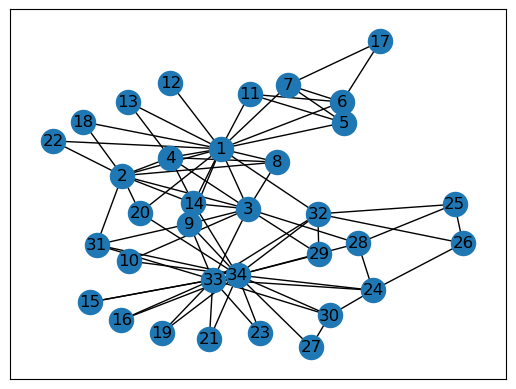

In [25]:
nx_display = nx.Graph()
nx_display.add_edges_from(edge_list)

pos = nx.kamada_kawai_layout(nx_display)
nx.draw_networkx(nx_display, pos, with_labels=True)
plt.show()

Below we also see how we can extract a degree view for a graph to see the dispersion of degrees amongst the vertices. This also works for directed graphs by using the `G.in_degree()` and `G.out_degree()` methods.

In [26]:
degrees = G.degree()
print(degrees)

[16 9 10 6 3 4 4 4 5 2 3 1 2 5 2 2 2 2 2 3 2 2 2 5 3 3 2 4 3 4 4 6 12 17]


Using Arkouda arrays we can also extract the node with maximum degree.

In [27]:
print(f"Node {G.nodes()[ak.argmax(degrees)]} has maximum degree of {ak.max(degrees)}")

Node 34 has maximum degree of 17


### **Subgraph Isomorphism**

The problem of motif finding in graphs is one of pattern matching with a smaller subgraph to search inside of a larger host graph. Here, we have an implementation of parallel VF2 that returns the subgraph mappings of vertices inside of the graph that contain the same structure as the given subgraph. Currently, our subgraph isomorphism method works only for property graphs. Further, it returns monomorphisms.

In [28]:
G_directed = ar.PropGraph()
edges_to_add = G.edges()
G_directed.add_edges_from(edges_to_add[0], edges_to_add[1])

In [29]:
subgraph = ar.PropGraph()
src = [0, 1, 2, 1]
dst = [1, 2, 0, 3]
subgraph.add_edges_from(ak.array(src), ak.array(dst))

In [33]:
n = 10
m = 100
s = 2
x = 1
y = 1

In [34]:
import time

### Build graph from randomly generated source and destination arrays.
# 1. Use Arkouda's randint to generate the random edge arrays.
src = ak.randint(0, n, m, seed=s*2)
dst = ak.randint(0, n, m, seed=s*4)

# 2. Build temporary property graph to get sorted edges and nodes lists.
temp_prop_graph = ar.PropGraph()
start = time.time()
temp_prop_graph.add_edges_from(src, dst)
end = time.time()
build_time = end - start
print(f"Building property graph with {len(temp_prop_graph)} vertices and "
        f"{temp_prop_graph.size()} "
        f"edges took {round(build_time,2)} seconds.")

### Generate node labels and edge relationships for the graph.
# 1. Extract node and edge information.
num_edges = temp_prop_graph.size()
num_nodes = len(temp_prop_graph)
edges = temp_prop_graph.edges()
nodes = temp_prop_graph.nodes()

# 2. Generate sets of node labels and edge relationships.
labels_set = ak.array(["lbl" + str(x) for x in range(x)])
relationships_set = ak.array(["rel" + str(y) for y in range(y)])

# 3. Give edges and nodes some labels and relationships.
node_labels = labels_set[ak.randint(0, len(labels_set), num_nodes)]
edge_relationships = relationships_set[ak.randint(0, len(relationships_set), num_edges)]

# 4. Create dataframe to load into a new property graph.
edge_df = ak.DataFrame({"src":edges[0], "dst":edges[1], "relationships":edge_relationships})
node_df = ak.DataFrame({"nodes":nodes, "labels":node_labels})

# 5. Create new property graph with node labels and edge relationships.
prop_graph = ar.PropGraph()
prop_graph.load_edge_attributes(edge_df, source_column="src", destination_column="dst",
                                relationship_columns=["relationships"])
prop_graph.load_node_attributes(node_df, node_column="nodes", label_columns=["labels"])

### Create the subgraph we are searching for.
# 1. Create labels and relationships to search for.
src_subgraph = ak.array([0, 1, 2])
dst_subgraph = ak.array([1, 2, 0])
labels1_subgraph = ak.array(["lbl1", "lbl1", "lbl1"])
labels2_subgraph = ak.array(["lbl2", "lbl2", "lbl2"])
rels1_subgraph = ak.array(["rel1", "rel1", "rel1"])
rels2_subgraph = ak.array(["rel2", "rel2", "rel2"])

#2. Populate the subgraph.
subgraph = ar.PropGraph()
edge_df_h = ak.DataFrame({"src":src_subgraph, "dst":dst_subgraph,
                        "rels1":rels1_subgraph, "rels2":rels2_subgraph})
node_df_h = ak.DataFrame({"nodes": src_subgraph, "lbls1":labels1_subgraph,
                            "lbls2":labels2_subgraph})
subgraph.load_edge_attributes(edge_df_h, source_column="src", destination_column="dst",
                                relationship_columns=["rels1","rels2"])
subgraph.load_node_attributes(node_df_h, node_column="nodes", label_columns=["lbls1","lbls2"])

### Run subgraph isomorphism.
isos = ar.subgraph_isomorphism(prop_graph,subgraph)

Building property graph with 10 vertices and 67 edges took 2.54 seconds.


RuntimeError: cannot cast class to type - runtime types not compatible

In [ ]:
print(f"We found {len(isos)/4} triangles with tails inside of the karate graph")

We found 1848.0 triangles with tails inside of the karate graph
